In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from operator import itemgetter
import statsmodels.api as sm
import time
import xgboost as xgb
from random import shuffle
from random import randint

In [2]:
pd.set_option("display.max_rows",50)
df=pd.read_csv('Phishing_Legitimate_full.csv')
dfn=pd.read_csv('Phishing_Legitimate_full.csv')
#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df.drop(['id'],axis=1,inplace=True)

In [3]:
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [9]:
#podział na df i df znormalizowane 
dummLev = pd.get_dummies(dfn[catFeatures], drop_first=True)
dfn = pd.concat([dfn[numFeatures], dummLev, dfn[[target]]], axis=1)
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

In [10]:
# standaryzacja zmiennych
dfn[numFeatures] = dfn[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [11]:
features = df.columns.tolist()
features.remove(target)
print(features)
featuresn = dfn.columns.tolist()
featuresn.remove(target)
print(featuresn)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumNumericChars', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'DoubleSlashInPath', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'ExtMetaScriptLinkRT', 'UrlLengthRT', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'PctExtNullSelfRedirectHyperlinksRT']
['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscor

In [12]:
rhs = "+".join(features)
rhs

'NumDots+SubdomainLevel+PathLevel+UrlLength+NumDash+NumDashInHostname+NumUnderscore+NumPercent+NumQueryComponents+NumAmpersand+NumNumericChars+HostnameLength+PathLength+QueryLength+NumSensitiveWords+AtSymbol+TildeSymbol+NumHash+NoHttps+RandomString+IpAddress+DomainInSubdomains+DomainInPaths+HttpsInHostname+DoubleSlashInPath+EmbeddedBrandName+PctExtHyperlinks+PctExtResourceUrls+ExtFavicon+InsecureForms+RelativeFormAction+ExtFormAction+AbnormalFormAction+PctNullSelfRedirectHyperlinks+FrequentDomainNameMismatch+FakeLinkInStatusBar+RightClickDisabled+PopUpWindow+SubmitInfoToEmail+IframeOrFrame+MissingTitle+ImagesOnlyInForm+ExtMetaScriptLinkRT+UrlLengthRT+SubdomainLevelRT+PctExtResourceUrlsRT+AbnormalExtFormActionR+PctExtNullSelfRedirectHyperlinksRT'

In [13]:
def CVTest(nFolds = 5, randomState=2020, debug=False):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy do zapisywania wyników
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Estymacja modelu GLM
        mod = sm.GLM.from_formula(formula="CLASS_LABEL ~ "+rhs,
                                  data=df.iloc[train], family=sm.families.Binomial())
        res = mod.fit()
        predsTrain = res.predict()
        preds = res.predict(df.iloc[test])
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score((df.CLASS_LABEL.iloc[train]==1),predsTrain)
        testScore = roc_auc_score((df.CLASS_LABEL.iloc[test]==1),preds)
        
        # Zapisanie wyników dopasowania w foldach
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

def CVTestSVM(nFolds = 5, randomState=2020, debug=False, sampleSize = 5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(dfn.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2020, tol=0.001, cache_size=500, *args, **kwargs)
        # Wyświetlenie wywołania funkcji
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego
        sampleSize = sampleSize
        X = dfn.iloc[train].sample(sampleSize)
        # Trenowanie modelu
        clf.fit(X[features], X[target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfn.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfn.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(dfn.iloc[test].index.tolist().copy())
        
        # Policzenie statystyka lda każdego foldu
        trainScore = roc_auc_score((dfn[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((dfn[target].iloc[test]==1), preds)
        
        # Zapisanie wyników do list
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices
def CVTestKNN(features=featuresn, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfn.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfn.iloc[train][features], dfn.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfn.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfn.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(dfn.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((dfn[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((dfn[target].iloc[test]==1), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [14]:
def plotROCs(results):
   
    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

In [15]:
dfn1 = dfn.copy()
dfn1["SubmitInfoToEmail"]=dfn1["SubmitInfoToEmail"]*4
dfn1["InsecureForms"]=dfn1["InsecureForms"]*2
dfn1["ImagesOnlyInForm"]=dfn1["ImagesOnlyInForm"]*4
trainResults, testResults, predictions, indices = CVTestKNN(features=features,n_neighbors=14, n_jobs=-1, p=1)
print(np.mean(testResults))

modelkNN = {
    "name":"KNN",
    "description":"Pierwszy dopracowany model KNN, 14 sąsiadów z wszystkimi zmiennymi",
    "specification":'n_neighbors=30, n_jobs=-1, p=1, features=features',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9891237795279576


In [18]:
trainResults, testResults, predictions, indices = CVTest(nFolds = 5, randomState=2020)
print(np.mean(trainResults), np.mean(testResults))
modelLogit = {
    "name":"Logit",
    "description":"Model Logit ",
    "specification":'nFolds= 5 randomState = 2020',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9855539816948031 0.9838801178113986


In [16]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="rbf", C=10)
print(np.mean(testResults))
modelSVM = {
        "name":f"SVM RBF = 10",
        "description":"Testy z C i kernelem RBF",
        "specification":'kernel="rbf" C=10,',
        "trainResults":trainResults.copy(),
        "testResults":testResults.copy(),
        "predictions":predictions.copy(),
        "indices":indices.copy(),
}

0.9941931479647931


In [19]:
res2plot = []
predNames = []
true = df[target].sort_index()
for result in [modelkNN, modelLogit, modelSVM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    # Dodajmy kolumnę z predykcjami na podstawie nazwy z pliku
    # Wyczyścimy nazwy modeli aby zlikwidować spacje i pozbyć się niepotrzebnych składników
    cleanName = (result['name']).replace(" ", "_").split("_")[0]
    predNames.append(f"pred_{cleanName}")
    df[f"pred_{cleanName}"] = pred
    res2plot.append((true, pred, result["name"]))

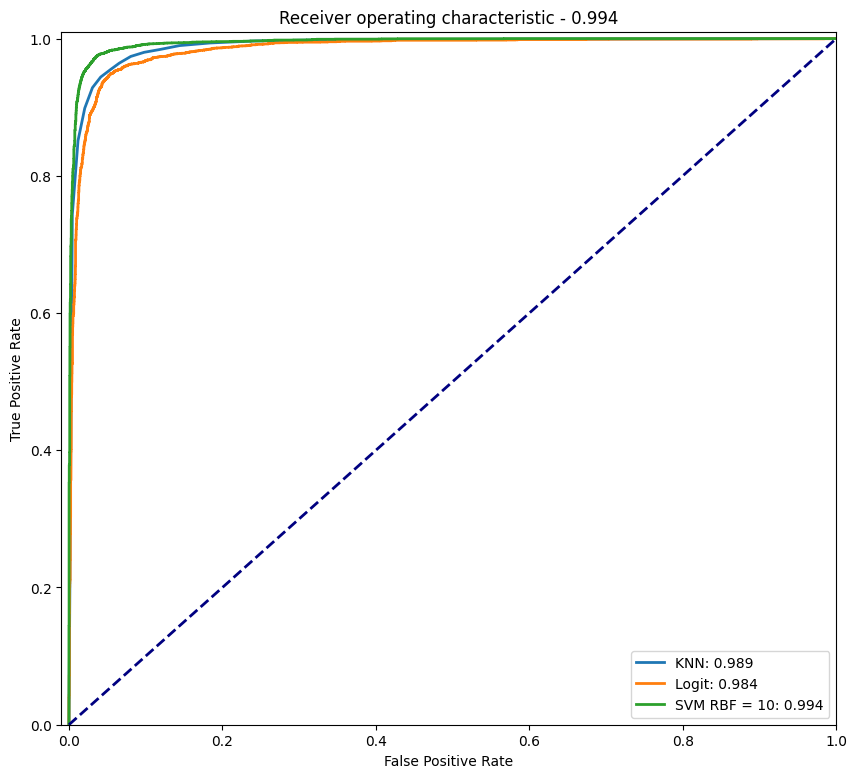

In [20]:
plotROCs(res2plot)

In [17]:
#porównujemy predykcje z różnych modeliu
df[predNames].sample(10)

,pred_KNN,pred_Logit,pred_SVM
7432,0.214286,0.106141,0.021476
2210,1.000000,0.996999,0.999998
2650,1.000000,0.986949,0.941433
3803,0.928571,0.854066,0.976921
3006,1.000000,0.999826,0.991775
2838,1.000000,0.998246,1.000000
2153,0.785714,0.334204,0.936730
2798,1.000000,0.996385,1.000000
1975,0.142857,0.394561,0.328274
1449,1.000000,1.000000,0.911116


In [18]:
#sprawdzamy też korelacje między wynikami modeli
df[predNames].corr()

,pred_KNN,pred_Logit,pred_SVM
pred_KNN,1.000000,0.929682,0.951547
pred_Logit,0.929682,1.000000,0.947706
pred_SVM,0.951547,0.947706,1.000000


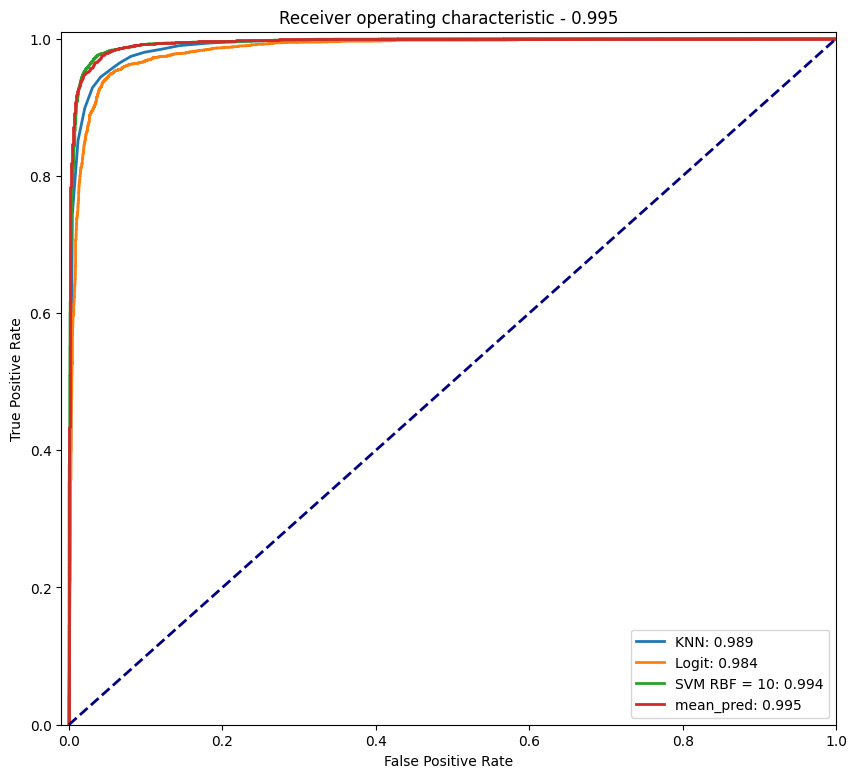

In [22]:
# sprawdzimy jak wygląda wyres ROC dla średniej z wyników modeli
df["pred_mean"] = df[['pred_KNN','pred_Logit','pred_SVM']].mean(axis=1)
res2plot.append((true, df["pred_mean"].sort_index().tolist(), "mean_pred"))

plotROCs(res2plot)

In [23]:
# robimy regresję logistyczną dla wyników modeli
mod = sm.GLM.from_formula(formula="CLASS_LABEL ~ "+"+".join(predNames),
                          data=df, family=sm.families.Binomial())
res = mod.fit()
predsStack = res.predict()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            CLASS_LABEL   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -901.87
Date:                Wed, 14 Jun 2023   Deviance:                       1803.7
Time:                        08:33:50   Pearson chi2:                 6.07e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.7006
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.2728      0.147    -35.797      0.000      -5.561      -4.984
pred_KNN       3.3196      0.272     12.187      0.000       2.786       3.853
pred_Logit     1.4148      0.253      5.595      0.000       0.919       1.910
pred_SVM       5.1372      0.261     19.697      0.000       4.626       5.648
==============================================================================
"""

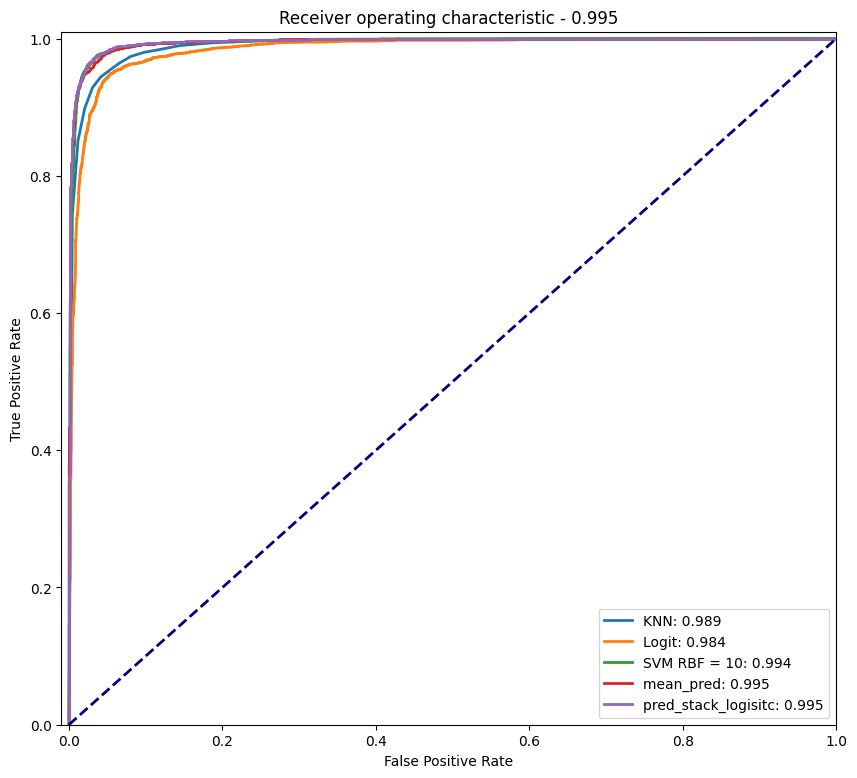

In [24]:
#sprawdzamy na wykresie jak wyglądają wyniki regresji dla wyników modeli
df["pred_stack_logisitc"] = predsStack
res2plot.append((true, df["pred_stack_logisitc"].sort_index().tolist(), "pred_stack_logisitc"))

plotROCs(res2plot)

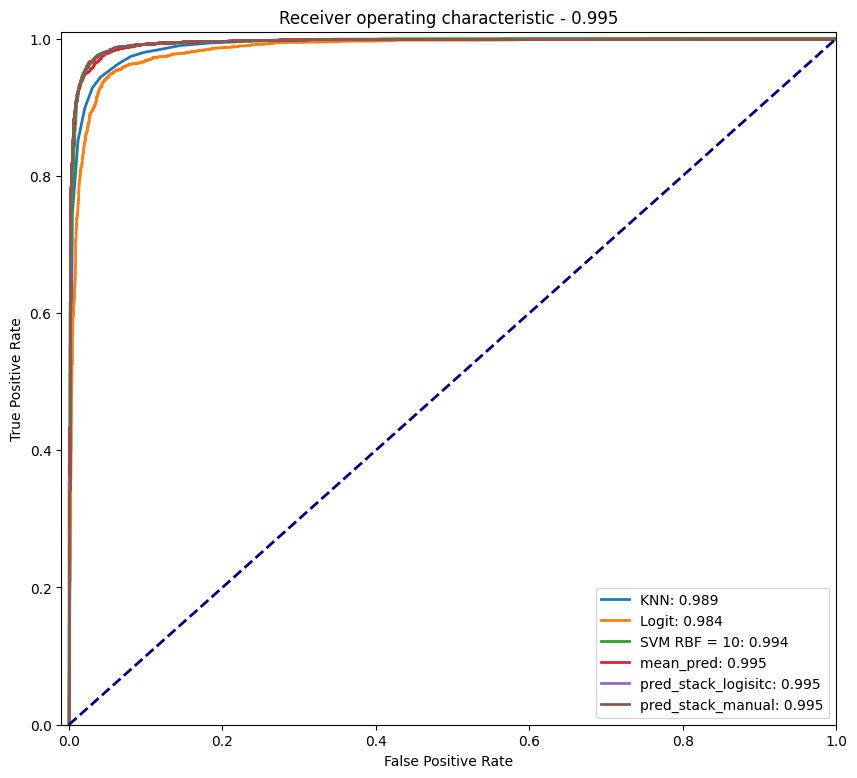

In [25]:
#dodajemy manualnie wagi, liczymy średnia i sprawdzamy na wykresie
df["pred_stack_manual"] = (3*df["pred_KNN"] + 5*df["pred_SVM"] + df["pred_Logit"])/9
res2plot.append((true, df["pred_stack_manual"].sort_index().tolist(), "pred_stack_manual"))

plotROCs(res2plot)

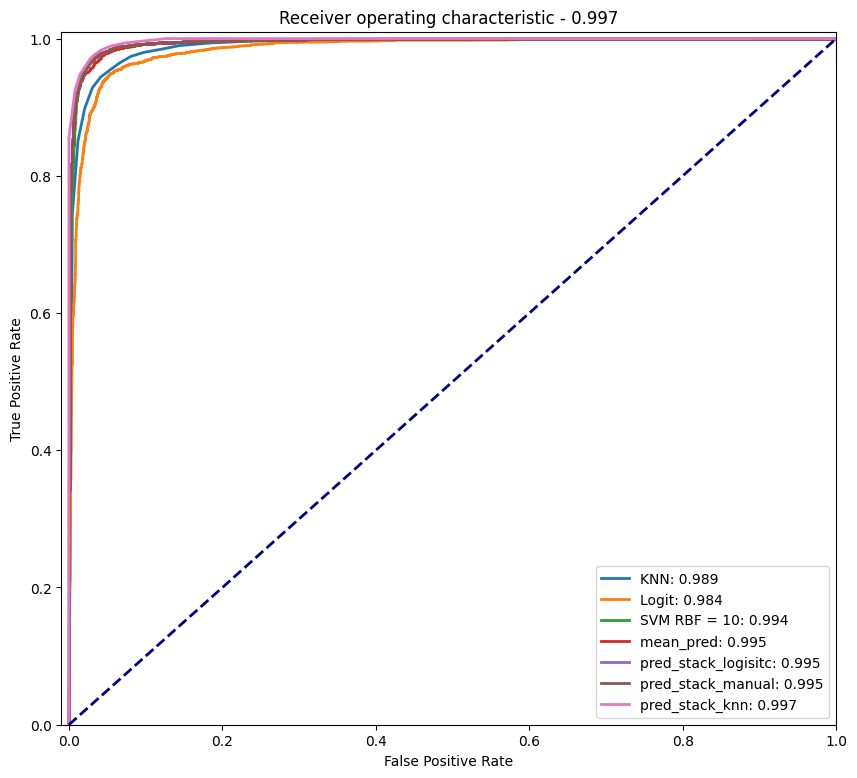

In [26]:
#sprawdzamy jakie wyniki osiągnie wykorzystując KNN
clf = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=2).fit(df[predNames], df[target])
predsStack2 = clf.predict_proba(df[predNames])[:,1]
df["pred_stack_knn"] = predsStack2
res2plot.append((true, df["pred_stack_knn"].sort_index().tolist(), "pred_stack_knn"))

plotROCs(res2plot)
#najlepszy wynik ale może to być złudne